In [1]:
import os
import json
import random
import numpy as np
from six.moves import range

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import lc_options
from utils import lc_utilities as utils
from rouge import Rouge
from similarity.normalized_levenshtein import NormalizedLevenshtein
from gensim.models import KeyedVectors
from scipy import spatial
word2vec = KeyedVectors.load_word2vec_format(
    'data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [2]:
params = {
    'inputJson': "data/processed_data/xprocessed_data.json",
    'useGPU': False,
    # A-Bot checkpoint
    'startFrom': "./checkpoints/xsum/abot_ep_97.vd",
    'qstartFrom': "./checkpoints/xsum/qbot_ep_161.vd",
    'beamSize': 5,
}

# RNG seed
manualSeed = 1597
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if params['useGPU']:
    torch.cuda.manual_seed_all(manualSeed)

print('Loading json file: ' + params['inputJson'])
with open(params['inputJson'], 'r') as fileId:
    info = json.load(fileId)

wordCount = len(info['word2ind'])
# Add <START> and <END> to vocabulary
info['word2ind']['<START>'] = wordCount + 1
info['word2ind']['<END>'] = wordCount + 2
startToken = info['word2ind']['<START>']
endToken = info['word2ind']['<END>']
# Padding token is at index 0
vocabSize = wordCount + 3
print('Vocab size with <START>, <END>: %d' % vocabSize)

# Construct the reverse map
info['ind2word'] = {
    int(ind): word
    for word, ind in info['word2ind'].items()
}

Loading json file: data/processed_data/xprocessed_data.json
Vocab size with <START>, <END>: 10446


In [3]:
def loadModel(params, agent='abot'):
    # should be everything used in encoderParam, decoderParam below
    encoderOptions = [
        'encoder', 'vocabSize', 'embedSize', 'rnnHiddenSize', 'numLayers',
        'useHistory', 'numRounds', 'dropout', 'useSumm'
    ]
    decoderOptions = [
        'decoder', 'vocabSize', 'embedSize', 'rnnHiddenSize', 'numLayers',
        'dropout'
    ]
    modelOptions = encoderOptions + decoderOptions

    mdict = None
    gpuFlag = params['useGPU']
    startArg = 'startFrom' if agent == 'abot' else 'qstartFrom'
    assert params[startArg], "Need checkpoint for {}".format(agent)

    if params[startArg]:
        print('Loading model (weights and config) from {}'.format(
            params[startArg]))

        if gpuFlag:
            mdict = torch.load(params[startArg])
        else:
            mdict = torch.load(params[startArg],
                map_location=lambda storage, location: storage)

        # Model options is a union of standard model options defined
        # above and parameters loaded from checkpoint
        modelOptions = list(set(modelOptions).union(set(mdict['params'])))
        for opt in modelOptions:
            if opt not in params:
                params[opt] = mdict['params'][opt]

            elif params[opt] != mdict['params'][opt]:
                # Parameters are not overwritten from checkpoint
                pass

    # Initialize model class
    encoderParam = {k: params[k] for k in encoderOptions}
    decoderParam = {k: params[k] for k in decoderOptions}

    encoderParam['startToken'] = encoderParam['vocabSize'] - 2
    encoderParam['endToken'] = encoderParam['vocabSize'] - 1
    decoderParam['startToken'] = decoderParam['vocabSize'] - 2
    decoderParam['endToken'] = decoderParam['vocabSize'] - 1

    if agent == 'abot':
        encoderParam['type'] = params['encoder']
        decoderParam['type'] = params['decoder']
        encoderParam['isAnswerer'] = True
        from lc.models.lc_answerer import Answerer
        model = Answerer(encoderParam, decoderParam)

    elif agent == 'qbot':
        encoderParam['type'] = params['qencoder']
        decoderParam['type'] = params['qdecoder']
        encoderParam['isAnswerer'] = False
        encoderParam['useSumm'] = False
        from lc.models.lc_questioner import Questioner
        model = Questioner(
            encoderParam,
            decoderParam,
            summGenSize=200)

    if params['useGPU']:
        model.cuda()

    if mdict:
        model.load_state_dict(mdict['model'])
        
    print("Loaded agent {}".format(agent))
    return model

In [77]:
ind_map = lambda words: np.array([info['word2ind'].get(word, info['word2ind']['UNK']) 
                                  for word in words], dtype='int64')

tokenize = lambda string: ['<START>'] + word_tokenize(string) + ['<END>']

to_str_gt = lambda w: str(" ".join([info['ind2word'][x] for x in filter(
        lambda x:x>0,w.data.cpu().numpy())]))[8:-6]

to_str_pred = lambda w, l: str(" ".join([info['ind2word'][x] for x in list( filter(
        lambda x:x>0,w.data.cpu().numpy()))][:l.data.cpu()[0]]))[8:]

def var_map(tensor):
    return Variable(tensor.unsqueeze(0), volatile=True)

In [5]:
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anest\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anest\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def string_conv(string):

    words = nltk.word_tokenize(string)
    words = [word.lower() for word in words if word.isalnum()]
    string = word_tokenize(' '.join(words))
    
    clear_seq = []
    for word in string:
        if (word not in stop_words):
            clear_seq.append(word)
            
    string = ' '.join(clear_seq)
    string_tokens = tokenize(string)
    string = ind_map(string_tokens)
    string_tensor = var_map(torch.from_numpy(string))
    string_lens = var_map(torch.LongTensor([len(string)]))
    
    return string_tensor, string_lens

In [7]:
def word2vec_transform(sequence):
    vectorized = []
    words = word_tokenize(sequence)
    seq_tokens = [word.lower() for word in words if word.isalnum()]
    
    for word in seq_tokens:
        try:
            vectorized.append(word2vec[word])
        except:
            vectorized.append(np.zeros(300,))
            
    return np.array(vectorized)

def similarity_cosine(vec1, vec2):
    cosine_distance = spatial.distance.cosine(vec1, vec2)
    return 1-cosine_distance


In [22]:
doc_data = json.load(open('data/generated_data/xgen_dataset.json'))['data']['dialogs']
summ_data = json.load(open('data/generated_data/xsummary_dataset.json'))

eval_data = []

for doc in doc_data:
    eval_data.append({
        'doc': doc['document'],
        'summ': summ_data[doc['summary']]
    })
    
eval_data = eval_data[0:765]

In [66]:
doc_data[84]['document']

"Wednesday's clash between Sunderland and Manchester City at the Stadium of Light saw a figure dressed as the superhero walk among the players.\nBradley Minto, 18, of Fordfield Road, Sunderland was charged with entering an area designated for football matches.\nMr Minto will appear at Sunderland Magistrates' Court on 23 December.\nManchester City won the match 4-1."

In [67]:
summ_data[doc_data[84]['summary']]

'A teenager has been charged after allegedly going on to the pitch dressed as Spider-Man at a Premier League football match.'

In [79]:
numRounds = 10
beamSize = 5

summary_tensor, summary_lens = string_conv(summ_data[doc_data[814]['summary']])
document_tensor, document_lens = string_conv(doc_data[814]['document'])

aBot = None
qBot = None

# load aBot
if params['startFrom']:
    aBot = loadModel(params, 'abot')
    assert aBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
    aBot.eval()
    
# load qBot
if params['qstartFrom']:
    qBot = loadModel(params, 'qbot')
    assert qBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
    qBot.eval()


# prepare for dialogue
if aBot:
    aBot.eval(), aBot.reset()
    aBot.train(), aBot.reset()
    aBot.observe(-1, summary=summary_tensor, summaryLens=summary_lens, document=document_tensor,
                    documentLens=document_lens)

if qBot:
    qBot.eval(), qBot.reset()
    qBot.observe(-1, document=document_tensor,
                    documentLens=document_lens)
summ, summ_lens = qBot.predictSummary(inference='greedy')
print('A%s:' %round, to_str_pred(summ[0], summ_lens))
print(summary_lens)
# dialogue before summ generation
# for round in range(numRounds):
#     questions, quesLens = qBot.forwardDecode(
#         beamSize=beamSize, inference='sample')
#     qBot.observe(round, ques=questions, quesLens=quesLens)
#     aBot.observe(round, ques=questions, quesLens=quesLens)
#     answers, ansLens = aBot.forwardDecode(
#         beamSize=beamSize, inference='greedy')
#     aBot.observe(round, ans=answers, ansLens=ansLens)
#     qBot.observe(round, ans=answers, ansLens=ansLens)
    
#     summ, summ_lens = qBot.predictSummary(inference='greedy')
#     print('Q%s:' %round, to_str_pred(questions[0], quesLens))
#     print('A%s:' %round, to_str_pred(answers[0], ansLens))


C:\Users\anest\AppData\Local\Temp\ipykernel_26332\4003069411.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(tensor.unsqueeze(0), volatile=True)


Loading model (weights and config) from ./checkpoints/xsum/abot_ep_97.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/xsum/qbot_ep_161.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
A9: man charged firearm discharged UNK                                                                                                            
tensor([[14]])


achondroplasia may inherited autosomal dominant trait means child gets defective gene 1 parent 1 parent cases parent achondroplasia infant 50 chance inheriting disorder parents parents infant chances obesity                                                                                                                                                                                                                                                                                                                                                        

In [24]:
numRounds = 10
beamSize = 5

summs_eval = []
rouge_1 = [[],[],[],[],[],[],[],[],[],[]]
rouge_2 = [[],[],[],[],[],[],[],[],[],[]]
rouge_l = [[],[],[],[],[],[],[],[],[],[]]
leven = [[],[],[],[],[],[],[],[],[],[]]
word2v = [[],[],[],[],[],[],[],[],[],[]]

ques = []

for eval in eval_data:
    # load data
    summary_tensor, summary_lens = string_conv(eval['summ'])
    document_tensor, document_lens = string_conv(eval['doc'])
    
    aBot = None
    qBot = None
    
    # load aBot
    if params['startFrom']:
        aBot = loadModel(params, 'abot')
        assert aBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
        aBot.eval()
        
    # load qBot
    if params['qstartFrom']:
        qBot = loadModel(params, 'qbot')
        assert qBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
        qBot.eval()


    # prepare for dialogue
    if aBot:
        aBot.eval(), aBot.reset()
        aBot.train(), aBot.reset()
        aBot.observe(-1, summary=summary_tensor, summaryLens=summary_lens, document=document_tensor,
                        documentLens=document_lens)

    if qBot:
        qBot.eval(), qBot.reset()
        qBot.observe(-1, document=document_tensor,
                        documentLens=document_lens)
    
    # dialogue before summ generation
    for round in range(numRounds):
        questions, quesLens = qBot.forwardDecode(
            beamSize=beamSize, inference='greedy')
        qBot.observe(round, ques=questions, quesLens=quesLens)
        aBot.observe(round, ques=questions, quesLens=quesLens)
        answers, ansLens = aBot.forwardDecode(
            beamSize=beamSize, inference='greedy')
        aBot.observe(round, ans=answers, ansLens=ansLens)
        qBot.observe(round, ans=answers, ansLens=ansLens)
        summ, summ_lens = qBot.predictSummary(inference='greedy')
        
        ques.append(to_str_pred(questions[0], quesLens))
        rouge_scores = Rouge().get_scores(eval['summ'], to_str_pred(summ[0], summ_lens), avg=True)
        rouge_1[round].append(rouge_scores['rouge-1']['f'] * 100)
        rouge_2[round].append(rouge_scores['rouge-2']['f'] * 100)
        rouge_l[round].append(rouge_scores['rouge-l']['f'] * 100)
        
        leven[round].append(100*(1 -  NormalizedLevenshtein().distance(eval['summ'],  to_str_pred(summ[0], summ_lens))))
        word2v[round].append(100* (similarity_cosine(word2vec_transform(eval['summ']).mean(axis=0),word2vec_transform(to_str_pred(summ[0], summ_lens)).mean(axis=0))))

    summs_eval.append({
        'gt': eval['summ'],
        'gen': to_str_pred(summ[0], summ_lens)
    })

C:\Users\anest\AppData\Local\Temp\ipykernel_26332\4003069411.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(tensor.unsqueeze(0), volatile=True)


Loading model (weights and config) from ./checkpoints/xsum/abot_ep_97.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/xsum/qbot_ep_161.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/xsum/abot_ep_97.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/xsum/qbot_ep_161.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/xsum/abot_ep_97.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/xsum/qbot_ep_161.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/xsum/abot_ep_97.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/xsum/

ValueError: Hypothesis is empty.

In [53]:
summary_tensor

tensor([[10444,  6316,  4646,  2137,  6122,   227,  1281,  3822, 10443,  5924,
         10445]])

In [45]:
print(len(summs_eval))

sss = []
for sm in summs_eval:
    sss.append(sm['gen'])

691


In [51]:
set(sss)

{'UNK UNK UNK UNK                                                                                                                ',
 'UNK UNK lawyer gambia prosecutor international criminal court hague                                                                                                      ',
 'UNK UNK strike proved difference southampton beat west brom strengthen grip finish                                                                                                ',
 'UNK kanu recovering united states undergoing corrective heart surgery                                                                                                      ',
 'aston villa jordan amavi signed marseille loan view permanent move                                                                                                    ',
 'batsman UNK graeme van buuren extended contracts gloucestershire                                                                                                  

In [50]:
len(set(sss))

27

In [25]:
len(ques)

6911

In [27]:
len(set(ques))

929

In [16]:
print(set(ques))

{'what is the name of the 19 year old boy charged with sexual assault for the release of UNK ?', 'who is the chief executive of the university of dundee ?', 'who is the chief operating officer of UNK and UNK ?', 'what was the cause of death of UNK UNK ?', 'who is the chief executive of sina ?', 'what was the name of the UNK UNK medal ?', 'what type of burns did the UNK chamber of commerce say it was taking to agree a plan of action ?', 'what is the name of the bacc course that students are more likely to get into place with ?', 'who is the chief executive of the UNK ?', 'how many people were killed at the UNK hangings ?', 'who is the manager of the summer ?', 'how old was omar badreddin when he disappeared ?', 'how many people died in the UNK horizon oil spill ?', 'what does UNK stand for ?', 'in what year did dickinson claim that cosby UNK and raped her ?', 'what was the name of the american bomber plane that dropped an atomic bomb on hiroshima ?', 'how many people were killed in the 

{'how do 14 siblings disease any untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated', 'what makes experiencing any untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated', 'what makes experiencing may by untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated', 'how do you treat neuromuscular by untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated', 'how do 14 siblings by untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated', 'how do you do untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated', 'untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated', 'what makes experiencing may such by untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated untreated'}

In [390]:
print(ques[0].split())

['what', 'is', 'the', 'name', 'of', 'the', 'UNK', 'tv', 'presenter', 'and', 'dj', '?']


In [28]:
words = []
for q in ques:
    for w in q.split():
        words.append(w)
        
print(len(words))

77257


In [30]:
len(set(words))

1066

In [31]:
print(set(words))

{'programme', 'from', 'league', 'bit', 'closing', 'wonderful', 'convicted', 'does', 'officers', 'road', 'motivation', 'university', 'type', 'minute', 'doughty', 'heat', 'squad', 'contract', 'gbagbo', 'stand', 'invest', 'briton', 'amazon', 'money', 'welling', 'lacked', 'emotional', 'imb', 'more', 'lakes', 'show', 'describe', 'rspb', 'brexit', 'comparison', 'mission', 'this', 'jimmie', 'mistake', 'amid', 'same', 'account', 'cap', 'friendship', 'wasps', 'climbing', 'galloway', 'power', 'voters', 'approached', 'beer', 'caley', 'city', 'action', 'disappear', 'put', 'postal', 'for', 'collapse', 'likely', 'dropped', 'slipped', 'arrested', 'support', 'begin', 'remanded', 'photos', 'bankers', 'possible', 'hire', 'indonesia', 'big', 'path', 'opposition', 'matter', '2007', 'american', 'build', 'rooms', 'ramadi', 'sector', 'relatively', 'pacu', 'attack', 'hands', 'harvested', 'presenters', 'george', 'teaches', 'between', 'badreddin', 'gilbert', 'are', 'women', 'uk', 'firing', 'culture', 'used', 'f

In [32]:
rouge_scores = []
levenshtein_similarities = []
word2vec_similarities = []


for pair in summs_eval:
    rouge_scores.append(Rouge().get_scores(pair['gt'], pair['gen'], avg=True))
    levenshtein_similarities.append(1 -  NormalizedLevenshtein().distance(pair['gt'], pair['gen']))
    word2vec_similarities.append(similarity_cosine(word2vec_transform(pair['gt']).mean(axis=0),word2vec_transform(pair['gen']).mean(axis=0)))
    
common_words = []
for pair in summs_eval:
    gt_summ = pair['gt'].lower()
    gen_summ = pair['gen'].lower()
    for word in pair['gen'].split():
        if word in pair['gt'].split():
            common_words.append(word)

# set(common_words)
# len(set(common_words))

rouge_f1 = []
rouge_f2 = []
rouge_fl = []

for score in rouge_scores:
    rouge_f1.append(score['rouge-1']['f'])
    rouge_f2.append(score['rouge-2']['f'])
    rouge_fl.append(score['rouge-l']['f'])

# print(max(levenshtein_similarities))
# print(min(levenshtein_similarities))
print(sum(levenshtein_similarities) / len(levenshtein_similarities)* 100)
print('------------------------------')
# print(max(word2vec_similarities))
# print(min(word2vec_similarities))
print(sum(word2vec_similarities) / len(word2vec_similarities)*100)
print('------------------------------')
# print(max(rouge_f1))
# print(min(rouge_f1))
print(sum(rouge_f1) / len(rouge_f1)* 100)
print('------------------------------')
print(sum(rouge_f2) / len(rouge_fl) *100) 
print('------------------------------')
# print(max(rouge_fl))
# print(min(rouge_fl))
print(sum(rouge_fl) / len(rouge_fl)* 100)
            

17.15063816839961
------------------------------
34.192549250133254
------------------------------
0.7224554613257897
------------------------------
0.028943559414696913
------------------------------
0.7224554613257897


In [33]:
print(max(levenshtein_similarities))
print(min(levenshtein_similarities))
print(sum(levenshtein_similarities) / len(levenshtein_similarities)* 100)
print('------------------------------')
print(max(word2vec_similarities))
print(min(word2vec_similarities))
print(sum(word2vec_similarities) / len(word2vec_similarities)*100)
print('------------------------------')
print(max(rouge_f1))
print(min(rouge_f1))
print(sum(rouge_f1) / len(rouge_f1)* 100)
print('------------------------------')
print(max(rouge_f2))
print(min(rouge_f2))
print(sum(rouge_f2) / len(rouge_fl) *100) 
print('------------------------------')
print(max(rouge_fl))
print(min(rouge_fl))
print(sum(rouge_fl) / len(rouge_fl)* 100)

0.25139664804469275
0.06211180124223603
17.15063816839961
------------------------------
0.9309223428668159
0.06798935369057102
34.192549250133254
------------------------------
0.6249999954882812
0.0
0.7224554613257897
------------------------------
0.19999999555555567
0.0
0.028943559414696913
------------------------------
0.6249999954882812
0.0
0.7224554613257897


PER ROUNG

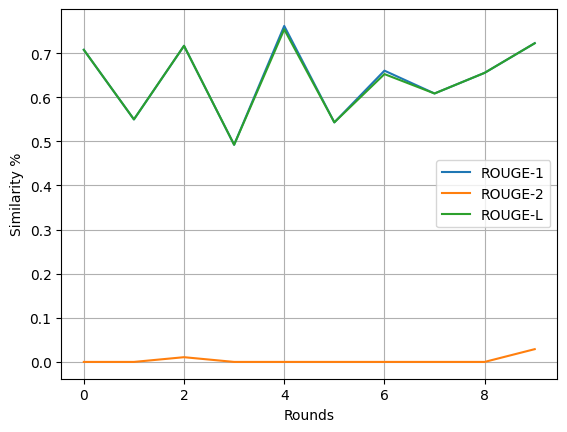

In [34]:
r1_plot = []
r2_plot = []
rl_plot = []
leven_plot = []
word2v_plot = []

for i in range(10):
    r1_plot.append(sum(rouge_1[i]) / len(rouge_1[i]))
    r2_plot.append(sum(rouge_2[i]) / len(rouge_2[i]))
    rl_plot.append(sum(rouge_l[i]) / len(rouge_l[i]))
    leven_plot.append(sum(leven[i]) / len(leven[i]))
    word2v_plot.append(sum(word2v[i]) / len(word2v[i]))
    
plot_data = {'ROUGE-1': r1_plot,'ROUGE-2': r2_plot,'ROUGE-L':rl_plot,}


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for dat in plot_data.keys():
    ax.plot([0,1,2,3,4,5,6,7,8,9], plot_data[dat], label=dat)
ax.set(ylabel='Similarity %', xlabel='Rounds', title='')
ax.grid()
    
plt.legend()
    
plt.show()


    # 

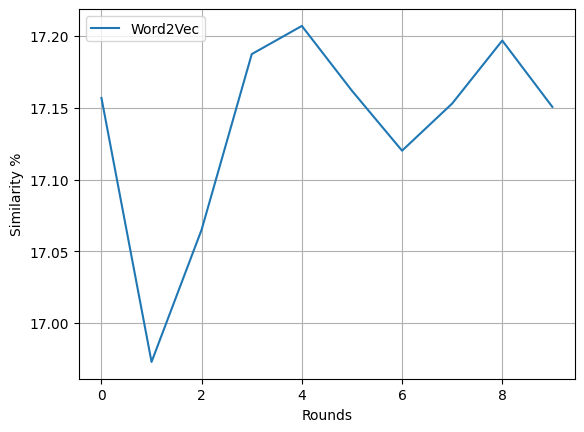

In [35]:
plot_data = {'Word2Vec':leven_plot}
# 'Word2Vec':word2v_plot
# 'Norm Levenshtein':leven_plot, 

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for dat in plot_data.keys():
    ax.plot([0,1,2,3,4,5,6,7,8,9], plot_data[dat], label=dat)
ax.set(ylabel='Similarity %', xlabel='Rounds', title='')
ax.grid()
    
plt.legend()
    
plt.show()